
## Exercice 3 : maximum de vraisemblance 2

On veut quantifier le lien entre deux variables pour lesquelles une relation lineaire semble exister, mais le bruit qui effecte les observations sur la deuxieme variable n'est clairement pas Gaussien.

Nous allons essayer de trouver la relation entre les variables a l'aide d'un modele de regression lineaire dont les parametres seront optimises en maximisant une vraissemblance plutot qu'en minimisant une erreur au carre.


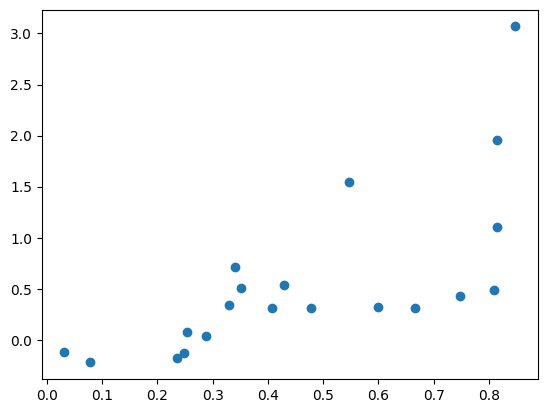

In [1]:
import numpy as np
import matplotlib.pyplot as plt


MyData=np.genfromtxt('QuantifiedDataExo1_3.csv')

plt.scatter(MyData[:,0],MyData[:,1])
plt.show()



### <span style="color:blue">QUESTION 3.1 :</span> 

Essayez de resoudre le probleme a l'aide de l'algorithme de regression lineaire de scikit-learn

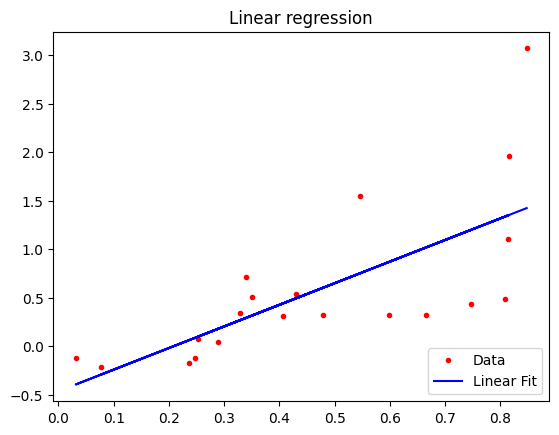

In [4]:
X=MyData[:,0]
Y=MyData[:,1]

import sklearn
from sklearn.linear_model import LinearRegression

lr = LinearRegression()

lr.fit(X[:, np.newaxis], Y)

fig = plt.figure()
plt.plot(X, Y, 'r.')
plt.plot(X, lr.predict(X[:, np.newaxis]), 'b-')
plt.legend(('Data', 'Linear Fit'), loc='lower right')
plt.title('Linear regression')
plt.show()


On peut constater que la pente de la courbe est legerement trop forte. Cette mauvaise estimation est due a trois observations a droite de la figure qui font un effet levier. La regression lineaire minimise l'erreur d'approximation au carre sur les observations d'apprentissage. De maniere sous-jacente cela se base sur l'hypothese que les erreurs d'approximation suivent une loi normale centree (et pas forcement reduite). Hors, les erreurs d'approximation autour d'un modele lineaire sont clairement non symetriques ici. Nous allons alors resoudre le probleme au sens du maximum de vraisemblance.

### <span style="color:blue">QUESTION 3.2 :</span> 

On va modeliser le probleme sous la forme :

$ypred_i = a * x_i +b \,,\, \forall i = 1, \ldots, n$
et $err_i= ypred_i-y_i$

ou les $x_i$ et $y_i$ sont les donnees d'apprentissage pour les observations $i$ dans $[1, 2, ..., n]$, et $ypred_i$ approche $y_i$. Les deux parametres du modele lineaire que l'on cherche a estimer sont $a$ et $b$. Afin de résoudre le probleme, on va alors repondre aux sous-questions suivantes :

#### <span style="color:blue">QUESTION 3.2.1 :</span> 
Codez une fonction qui calcul les erreurs d'approximations pour toutes les observations de $X$ et $Y$ avec un $a$ et un $b$ specifiques.

#### <span style="color:blue">QUESTION 3.2.2 :</span> 

Codez une fonction qui calcule la log-vraisemblance (ou la vraisemblance) de parametres pour lesquel l'erreur d'approximation suit une loi normale centree d'ecart type sigma. On donnera la valeur par defaut sigma=2

#### <span style="color:blue">QUESTION 3.2.3 :</span> 

Codez une fonction qui calcule la log-vraisemblance (ou la vraisemblance) de parametres pour lesquel l'erreur d'approximation suit une loi de chi2. On fixera par defaut le nombre de degres de liberte ddl=3 et l'echelle de la loi (scale) a 0.4. On fera très attention au fait que la densite de probabilite d'une valeur negative sera egale a zero avec la loi du chi2.

#### <span style="color:blue">QUESTION 3.2.4 :</span> 

Utilisez les fonctions de calcul de la (log-)vraisemblance pour trouver une relation lineaire qui semble raisonable, i.e. pour trouver les parametres a et b les plus vraisemblables. On pourra eventuellement s'aider d'une representation du nuage de points qui represente le 'score' attribue a chaque observation.


In [5]:
#CODE 2.1
def compute_errors(X,Y,theta):
    """
    returns a vector having the same size as X or Y which represents the errors
    with a 1D linear model of parameters theta=[a,b]
    """

    a = theta[0]
    b = theta[1]

    Y_pred = [a*x+b for x in X]
    errors = [Y[i]- Y_pred[i] for i in range(len(Y))]
    
    return errors


In [58]:

#CODE 2.2

from scipy.stats import norm

def likelihood_normal(X,Y,theta,sigma=2., verbose=False):
    """
    returns the likelihood of the 1D linear model with parameters theta=[a,b] and
    the errors following a normal law of std=sigma
    """

    errors=compute_errors(X,Y,theta)

    likelihood = np.prod(norm.pdf(x=errors, scale=sigma))

    if verbose:
        print(f"The gaussian likelihood is {likelihood}")

    return likelihood



In [56]:
#CODE 2.3

from scipy.stats import chi2

def likelihood_chi2(X,Y,theta,dof=3,sc=0.4, verbose=False):
    """
    returns the likelihood of the 1D linear model with parameters theta=[a,b] and
    the errors following a chi2 law of dof degrees of freedom
    """

    errors=compute_errors(X,Y,theta)

    likelihood = np.prod(chi2.pdf(x=errors, df=dof, scale=sc))

    if verbose:
        print(f"The chi2 likelihood is {likelihood}")

    return likelihood



In [59]:
#CODE 2.4

likelihood_normal(X,Y,[1.2,-0.3],sigma=2.,verbose=True)

likelihood_chi2(X,Y,[1.2,-0.6],dof=3,sc=0.4,verbose=True)

The gaussian likelihood is 2.989581231773985e-15
The chi2 likelihood is 2.7083496354647824e-07


np.float64(2.7083496354647824e-07)


### <span style="color:blue">QUESTION 3.3 :</span> 

Codez une fonction de descente de gradient pour apprendre les parametres optimaux du modele (a et b) avec les deux types de bruit consideres mais leurs parametres fixes aux valeurs par defaut.

Remarque: on **maximisera** idéalement la log-vraisemblance plutôt que la vraisemblance, ce qui est numeriquement plus efficace et conduit au même résultat.



In [62]:

def MinusLikelihood_normal(X,Y,theta,sigma=2.):
    return -likelihood_normal(X,Y,theta,sigma=sigma)

def MinusLikelihood_chi2(X,Y,theta,dof=3,sc=0.4):
    return -likelihood_chi2(X,Y,theta,dof=dof,sc=sc)


def Minus_Log_Likelihood_normal(X,Y,theta,sigma=2.):
    return -np.log(likelihood_normal(X,Y,theta,sigma=sigma))

def Minus_Log_Likelihood_chi2(X,Y,theta,dof=3,sc=0.4):
    return -np.log(likelihood_chi2(X,Y,theta,dof=dof,sc=sc))
#3.1: fonctions pour la descente de gradient

def Grad_function(f,X,Y,theta_loc,epsilon=1e-5):

    # A COMPLETER

    p = np.size(theta_loc)

    ApproxGrad = np.zeros(p)

    veps = np.zeros(p)

    for i in range(p):

        veps[:]=0.
        veps[i]+=epsilon

        ApproxGrad[i] = f(X, Y, theta_loc + veps) - f(X, Y, theta_loc) / epsilon
  
    return ApproxGrad

#descente de gradient avec alpha defini a la main

def grad_descent(funct,X,Y,theta_init,convspeedfactor=0.1,nbIterations=100):
    
    evo_f_theta=[]
    theta=theta_init.copy()
    for i in range(nbIterations):
        theta=theta-convspeedfactor*Grad_function(funct,X,Y,theta,0.001)
        evo_f_theta.append(funct(X,Y,theta))
        #print(theta)


    plt.plot(evo_f_theta)
    plt.show()

    return theta

/tmp/ipykernel_14892/353253145.py:9: RuntimeWarning: divide by zero encountered in log
  return -np.log(likelihood_normal(X,Y,theta,sigma=sigma))
/tmp/ipykernel_14892/353253145.py:30: RuntimeWarning: invalid value encountered in scalar subtract
  ApproxGrad[i] = f(X, Y, theta_loc + veps) - f(X, Y, theta_loc) / epsilon


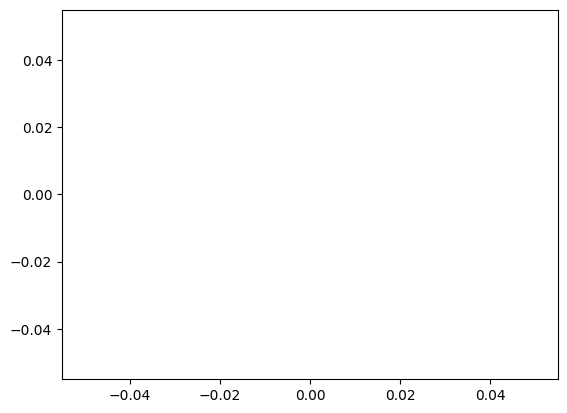

/tmp/ipykernel_14892/353253145.py:12: RuntimeWarning: divide by zero encountered in log
  return -np.log(likelihood_chi2(X,Y,theta,dof=dof,sc=sc))


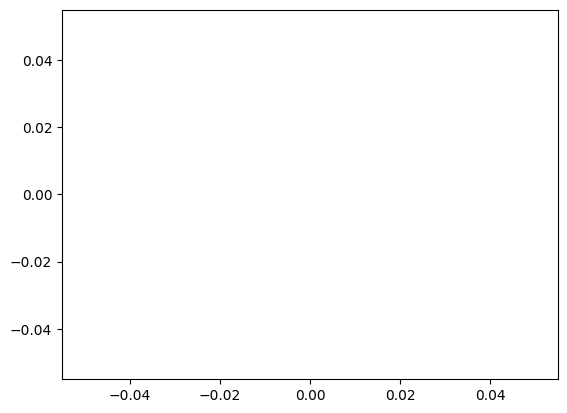

np.float64(nan)

In [63]:
#3.2: fonctions pour calculer le maximum de vraisemblance

#utilisation:
theta_init=np.array([0.,0.])
theta_optim=grad_descent(Minus_Log_Likelihood_normal,X,Y,theta_init,convspeedfactor=0.01,nbIterations=1000)


likelihood_normal(X,Y,theta_init,sigma=2.)
likelihood_normal(X,Y,theta_optim,sigma=2.)

#on constate que le resultat est tres proche de ce que l'on avait avec la regression lineaire
#classique, qui minimise la somme des erreurs au carre

#utilisation:
theta_init=np.array([0.,-1.])
theta_optim=grad_descent(Minus_Log_Likelihood_chi2,X,Y,theta_init,convspeedfactor=0.01,nbIterations=1000)

likelihood_chi2(X,Y,theta_init,dof=3,sc=0.4)
likelihood_chi2(X,Y,theta_optim,dof=3,sc=0.4)


l'optimisation marche aussi, meme si il faut faire tres attention au choix du theta_init (la densite du chi2 est nulle pour les erreurs negatives)... par contre :
  -> la vraisemblance est de 10e-7 au lieu de 10e-15
  -> le modele lineaire colle mieux a la majorite des donnees et est moins sensible aux donnees visiblement aberrantes


On peut alors plus faire confiance a la pente calculee avec le bruit de type chi2 que le bruit gaussien, MAIS en etant clair sur le fait qu'on aura une tendance loin d'etre negligeable de s'eloigner regulierement du modele lineaire de maniere non-symetrique par rapport au modele.


In [ ]:
"""
#Remarque : Generation de donnees dans cet exercice :

import numpy as np
import matplotlib.pyplot as plt
n = 20
X = np.random.uniform(size=n)
y = 1.2*X[:] + np.random.chisquare(1.,size=n)*0.4-0.5

plt.plot(X[], y, 'r.')
plt.show()

MyData=np.concatenate((X.reshape(-1,1),y.reshape(-1,1)),axis=1)
np.savetxt('J18_E4_QuantifiedData.csv',MyData)
"""